In [16]:
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
from utils import pareto_compare_plots, pareto_multicompare_plots, method_nice, reverse_metrics
from glob import glob
import pdb
import json
from tqdm import tqdm 
from collections import namedtuple
import numpy as np 


perf = namedtuple('perf',['method','dataset','seed'])
# rdir = 'results_r7'
rdirs = [
#     '../results_23-02-07/', 
    '../results_combined/', 
#     '../fair_gp/analysis/results/'
]
performances = {} 
methods = set()
datasets = set()
seeds = set()
seedcount = {}
from pathlib import Path
# for f in tqdm(glob(rdir+'/*.json')):
frames = []
for rdir in rdirs:
    for f in Path(rdir).rglob('*.json'):

        with open(f) as fh:
            perf = json.load(fh)
            
        for p in perf:
            for fold in ['train','test']:
                frame = {k:v for k,v in p.items() if k not in ['train','test']}
                frame['fold'] = fold
                method = frame['method']
                fairness = 'FPR' if 'fpr' in method else 'FNR'
                frame['fairness'] = fairness 
                frame['ML'] = 'Linear' if 'lr' in method else 'XGB'
                frame['base_method'] = method.split('_')[0]
                for metric,value in p[fold].items():
                    if metric.startswith('subgroup') or metric.startswith('auditor'):
                        if fairness.lower() not in metric:
                            continue
                        metric = metric.replace(fairness.lower(),'fairness')
                    frame[metric] = value
                frames.append(frame)
df_results = pd.DataFrame(frames)

In [17]:
df_results

,dataset,method,model,seed,fold,fairness,ML,base_method,accuracy,auc_prc,auc_roc,ave_precision_score,fpr,logloss,mae,precision,recall,subgroup_fairness
0,lsac_bar,fomo_nsga2_lr_fpr,fomo_nsga2_lr_fpr:archive(0),12669,train,FPR,Linear,fomo,0.934504,0.989046,0.839917,0.989047,0.036158,0.185438,0.116318,0.962140,0.969061,0.427466
1,lsac_bar,fomo_nsga2_lr_fpr,fomo_nsga2_lr_fpr:archive(0),12669,test,FPR,Linear,fomo,0.933383,0.989224,0.848451,0.989226,0.038587,0.181846,0.114226,0.959754,0.970440,0.387119
2,lsac_bar,fomo_nsga2_lr_fpr,fomo_nsga2_lr_fpr:archive(1),12669,train,FPR,Linear,fomo,0.934878,0.989056,0.840029,0.989057,0.036065,0.185554,0.116271,0.962246,0.969357,0.427466
3,lsac_bar,fomo_nsga2_lr_fpr,fomo_nsga2_lr_fpr:archive(1),12669,test,FPR,Linear,fomo,0.933196,0.989244,0.848771,0.989246,0.038120,0.181789,0.114127,0.960195,0.969751,0.389904
4,lsac_bar,fomo_nsga2_lr_fpr,fomo_nsga2_lr_fpr:archive(2),12669,train,FPR,Linear,fomo,0.934598,0.989063,0.840187,0.989064,0.035784,0.185793,0.116551,0.962506,0.968765,0.427466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109001,adult,fomo_nsga2_lr_fpr_linear,fomo_nsga2_lr_fpr_linear:archive(26),29756,test,FPR,Linear,fomo,0.809901,0.878642,0.889462,0.878817,0.100990,0.437828,0.238518,0.802708,0.821782,0.015842
109002,adult,fomo_nsga2_lr_fpr_linear,fomo_nsga2_lr_fpr_linear:archive(27),29756,train,FPR,Linear,fomo,0.849505,0.919545,0.921596,0.919639,0.088119,0.351374,0.220785,0.832707,0.875494,0.015594
109003,adult,fomo_nsga2_lr_fpr_linear,fomo_nsga2_lr_fpr_linear:archive(27),29756,test,FPR,Linear,fomo,0.812871,0.879290,0.891379,0.879468,0.095050,0.432367,0.237902,0.811024,0.815842,0.015842
109004,adult,fomo_nsga2_lr_fpr_linear,fomo_nsga2_lr_fpr_linear:archive(28),29756,train,FPR,Linear,fomo,0.856436,0.917461,0.920925,0.917560,0.086139,0.352002,0.219973,0.837383,0.885375,0.013663


# data cleanup

In [18]:
from utils import method_nice, fair_metrics, loss_metrics, reverse_metrics
df_results['method'] = df_results['method'].apply(lambda x: method_nice[x])
df_results = df_results.rename(columns={'subgroup_fairness':'Subgroup Fairness'})
for c in df_results.columns:
    if c in reverse_metrics and c in loss_metrics:
        df_results[loss_metrics[c]] = 1-df_results[c]

# Pareto Front: combined histogram/scatter with density contours

In [65]:
df_plt['method'].unique()

array(['FOMO-XGB', 'FOMO-LR-MLP', 'FOMO-XGB-MLP', 'FOMO-LR-Lin',
       'GerryFair-XGB', 'GerryFair-LR', 'FOMO-XGB-Lin', 'FOMO-LR'],
      dtype=object)

In [104]:
# palette= sns.color_palette("Spectral",8)
# del palette[8] 
# del palette[7] 
# del palette[6] 
# del palette[5] 
# del palette[4] 
# del palette[3] 
# del palette[2] 
# palette

/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


kde failed for FNR communities


/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/bill/miniconda3/envs/exp-fomo/lib/python3.9/site-packages/seaborn/distr

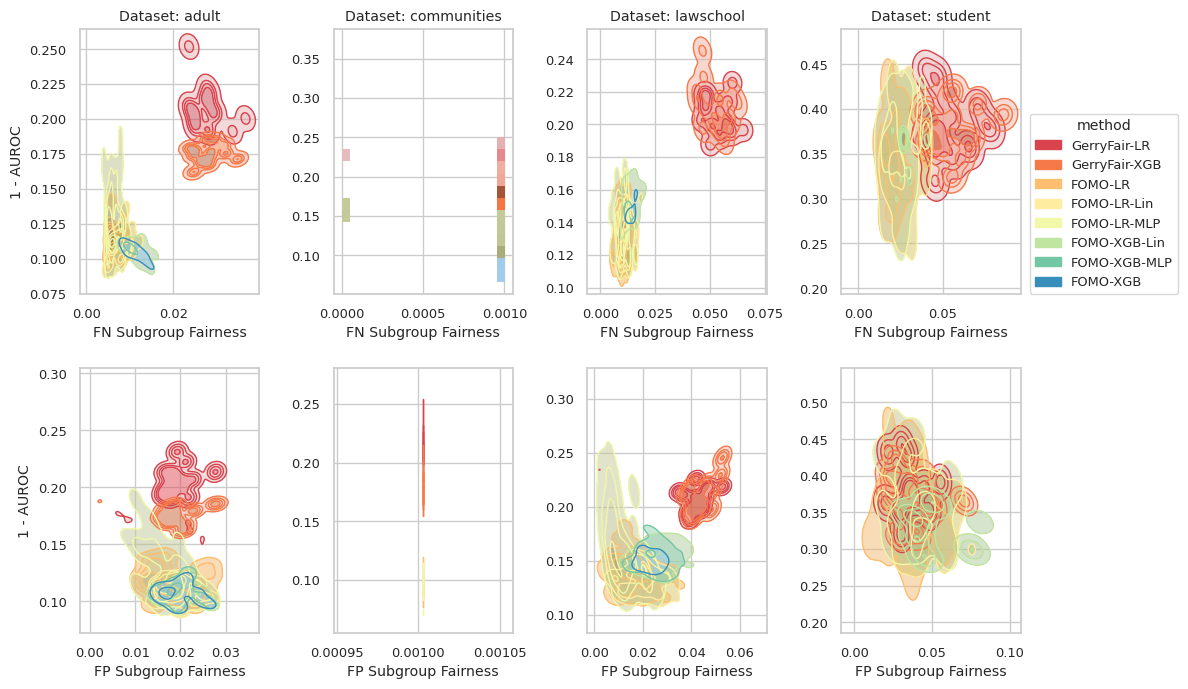

In [122]:
import matplotlib.pyplot as plt
sns.set(style='whitegrid',font_scale=0.85)
# size = 10
df_plt = df_results.copy()
df_plt = df_plt.loc[
#     (df_plt.method.str.contains('fnr'))
#     & 
    (df_plt.fold == 'test')
    &
    (df_plt.dataset.isin(['communities','adult','lawschool','student']))
]
hue_order = [
    'GerryFair-LR', 
    'GerryFair-XGB', 
    'FOMO-LR', 
    'FOMO-LR-Lin', 
    'FOMO-LR-MLP', 
    'FOMO-XGB-Lin', 
    'FOMO-XGB-MLP', 
    'FOMO-XGB'
] 
# s = np.argsort([method_nice[m] for m in models])
# hue_order = models #[models[i] for i in s]
    
x = 'Subgroup Fairness'
y = '1 - AUROC'
# hue = 'base_method'
hue = 'method'
style='ML'
col='dataset'
row='fairness'
palette='Spectral'

f, axs = plt.subplots(
    nrows = df_plt[row].nunique(), 
    ncols=df_plt[col].nunique(), 
    figsize=(12, 7)
)
i = 0
for r, dfr in df_plt.groupby(row):
    j = 0
    for c, dfrc in dfr.groupby(col):
        ax = axs[i,j]
        shared_args = dict(
            ax=ax, 
            data=dfrc,  
            x=x, 
            y=y,
            hue=hue,
            hue_order=hue_order,
            palette=palette
        )
        
        # Draw a combo histogram and scatterplot with density contours
#         xlim = ax.get_xlim()
#         ylim = ax.get_ylim()
        legend = i==0 and j+1 == df_plt[col].nunique()
        try:
            g = sns.kdeplot(**shared_args,
                        levels=5,
#                         color="w",
                        fill=True,
                        linewidths=1,
                        legend=legend,
                        alpha=0.5
                       )
            sns.kdeplot(**shared_args,
                        levels=5,
                        fill=False,
                        linewidths=1,
                        legend=False,
                       )
#             print()
        except:
            print('kde failed for',r,c)
#             sns.scatterplot(
#                 **shared_args, 
#                 s=5,
#                 legend = False,
#             )
            sns.histplot(**shared_args,
                         bins=20,
    #                      pthresh=.01,
                         thresh=1,
                         legend=False
                        )
            
#         ax.set_xlim(xlim)
#         ax.set_ylim(ylim)
        
        if i == 0: 
            ax.set_title(f'Dataset: {c}')
            
        ax.set_xlabel(f'{r[:2]} Subgroup Fairness')
#         if i+1 == df_plt[row].nunique():
#         else:
#             ax.set_xlabel('')
            
        if j == 0:
            ax.set_ylabel(f'{y.upper()}')
        else:
            ax.set_ylabel('')
            
        if legend:
            sns.move_legend(g, loc=[1.05,0])
            
        j += 1
    i += 1
    
# plt.tight_layout()

f.tight_layout(h_pad=2)
f.savefig('../../paper/figs/pareto_subplots_hist.pdf', bbox_inches='tight')

In [121]:
# plt.show()